In [27]:
!apt-get install git
!pip install medmnist --quiet
!pip install torch --quiet
!pip install torchvision --quiet
!pip install lightning  --quiet
!pip install matplotlib --quiet
!pip install scipy==1.11.3 --quiet
!pip torchkbnufft scipy==1.11.3 --quiet

'apt-get' �����ڲ����ⲿ���Ҳ���ǿ����еĳ���
���������ļ���

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-image 0.25.2 requires scipy>=1.11.4, but you have scipy 1.11.3 which is incompatible.

[notice] A new release of pip is available: 25.1.1 -

In [28]:
import torch
torch.cuda.is_available()

True

In [ ]:
import torch
from torch import nn

class ReLULayer(nn.Module):
    def __init__(self,
                 in_size: int,
                 out_size: int,
                 **kwargs):
        super().__init__()
        self.linear = nn.Linear(in_size, out_size, bias=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.linear(x)
        x = torch.relu(x)
        return x
    
SIREN_FACTOR = 30.0

class SineLayer(nn.Module):
    """
        Implicit Neural Representations with Periodic Activation Functions
        Implementation based on https://github.com/vsitzmann/siren?tab=readme-ov-file
    """
    def __init__(self, in_size, out_size, siren_factor=30., **kwargs):
        super().__init__()
        # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of factor 30
        self.siren_factor = siren_factor
        self.linear = nn.Linear(in_size, out_size, bias=True)

    def forward(self, x):
        x = self.linear(x)
        x = torch.sin(self.siren_factor * x)
        return x
    
WIRE_OMEGA = 20.0
WIRE_SIGMA = 10.0

class WIRELayer(nn.Module):
    """
        Implicit representation with Gabor nonlinearity
        Implementation based on https://github.com/vishwa91/wire
    """
    def __init__(self, in_size, out_size, wire_omega: float = 30.0, wire_sigma: float = 40.0, **kwargs):
        super().__init__()
        self.omega_0 = wire_omega  # Frequency of wavelet
        self.scale_0 = wire_sigma  # Width of wavelet
        self.freqs = nn.Linear(in_size, out_size, bias=True)
        self.scale = nn.Linear(in_size, out_size, bias=True)

    def forward(self, x):
        omega = self.omega_0 * self.freqs(x)
        scale = self.scale(x) * self.scale_0
        x = torch.cos(omega) * torch.exp(-(scale * scale))
        return x

class ShiftSineLayer(nn.Module):
    def __init__(self, in_size, out_size, siren_factor=30., **kwargs):
        super().__init__()
        self.siren_factor = siren_factor
        self.linear = nn.Linear(in_size, out_size, bias=True)

    def forward(self, x, beta=None):
        """
        x: (B, in_size)
        beta: (B, out_size)  
        """
        h = self.linear(x)               # Wh + b
        if beta is not None:
            # Automatically broadcast to batch dimension
            h = h + beta                 # Wh + b + β
        y = torch.sin(self.siren_factor * h)   # sin(ω0 (Wh + b + β))
        return y


class MLP(nn.Module):
    def __init__(self,
                 in_size: int,
                 out_size: int,
                 hidden_size: int = 128,
                 num_layers: int = 3,
                 layer_class: nn.Module = ReLULayer,
                 **kwargs):
        super().__init__()

        a = [layer_class(in_size, hidden_size, **kwargs)]
        for i in range(num_layers - 1):
            a.append(layer_class(hidden_size, hidden_size, **kwargs))
        a.append(nn.Linear(hidden_size, out_size))
        self.layers = nn.ModuleList(a)        

    def forward(self, x: torch.Tensor):
        for layer in self.layers:
            x = layer(x)
        return x
    
    
class ModulatedSIREN(nn.Module):
    def __init__(self,
                 in_size: int,
                 out_size: int,
                 hidden_size: int = 128,
                 num_layers: int = 3,
                 siren_factor: float = 30.0,
                 **kwargs):
        super().__init__()

        layers = []
        layers.append(ShiftSineLayer(in_size, hidden_size,
                                     siren_factor=siren_factor, **kwargs))
        for _ in range(num_layers - 1):
            layers.append(ShiftSineLayer(hidden_size, hidden_size,
                                         siren_factor=siren_factor, **kwargs))
        layers.append(nn.Linear(hidden_size, out_size))
        self.layers = nn.ModuleList(layers)

    def forward(self, x: torch.Tensor, betas=None):
        if betas is None:
            betas = [None] * (len(self.layers) - 1)

        for i, layer in enumerate(self.layers[:-1]):
            beta = betas[i]
            x = layer(x, beta=beta)

        x = self.layers[-1](x)
        return x


Image shape: torch.Size([224, 224, 1])
Max: tensor(0.8980) Min: tensor(0.)


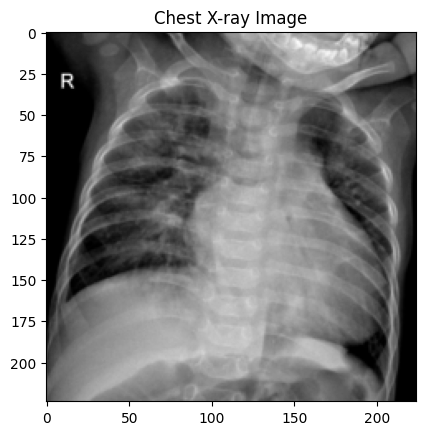

In [30]:
from medmnist import BreastMNIST, RetinaMNIST, PneumoniaMNIST
from torchvision.transforms.functional import pil_to_tensor
import matplotlib.pyplot as plt

IMAGE_SIZE = 224  # ChestMNIST offers sizes: 28, 64, 128, 224
chest_dataset = PneumoniaMNIST(split="val",
                           download=True,
                           size=IMAGE_SIZE)

# INRs are trained on only 1 scene. We only want 1 image.
pil_image, _ = chest_dataset[1]

gt_image = pil_to_tensor(pil_image)
gt_image = gt_image.moveaxis(0, -1)  # Convert to torch.Tensor
gt_image = gt_image.to(torch.float32) / 255.0  # Normalize image between [0.0, 1.0]
print("Image shape:", gt_image.shape)
print("Max:", gt_image.max(), "Min:", gt_image.min())
plt.imshow(gt_image, cmap='gray')
plt.title('Chest X-ray Image')
plt.show()

In [31]:
import torch
from torch.utils.data import Dataset, DataLoader
import random
import numpy as np


POINTS_PER_SAMPLE = 2048

class RandomPointsDataset(Dataset):
    def __init__(self, image: torch.Tensor, points_num: int = POINTS_PER_SAMPLE):
        super().__init__()
        self.device = "cpu"
        self.points_num = points_num
        assert image.dtype == torch.float32
        self.image = image.to(self.device)  # (H, W, ..., C)
        self.dim_sizes = self.image.shape[:-1]  # Size of each spatial dimension

        # To help us define the input/output sizes of our network later
        # we store the size of our input coordinates and output values
        self.coord_size = len(self.image.shape[:-1])  # Number of spatial dimensions
        self.value_size = self.image.shape[-1]  # Channel size

    def __len__(self):
        return 1

    def __getitem__(self, idx: int):
        # Create random sample of pixel indices
        point_indices = [torch.randint(0, i, (self.points_num,), device=self.device) for i in self.dim_sizes]

        # Retrieve image values from selected indices
        point_values = self.image[tuple(point_indices)]

        # Convert point indices into normalized [-1.0, 1.0] coordinates
        point_coords = torch.stack(point_indices, dim=-1)
        spatial_dims = torch.tensor(self.dim_sizes, device=self.device)
        point_coords_norm = point_coords / (spatial_dims / 2) - 1

        # The subject index is also returned in case the user wants to use subject-wise learned latents
        return point_coords_norm, point_values

dataset = RandomPointsDataset(gt_image, points_num=POINTS_PER_SAMPLE)
# We set a batch_size of 1 since our dataloader is already returning a batch of points.
dataloader = DataLoader(dataset, batch_size=1, num_workers=0, pin_memory=True)

In [32]:
from typing import Tuple, List, Optional
import numpy as np
import torch
import matplotlib.pyplot as plt

In [33]:
# We will track visual results every few epochs and visualize them after training
def plot_reconstructions(progress_ims: List[Tuple[int, torch.Tensor]], gt_im: torch.Tensor):
    ncols = len(progress_ims) + 1
    fig_width = 5
    fig, axs = plt.subplots(ncols=ncols, figsize=(ncols*fig_width, fig_width))
    # Plot all reconstructions images predicted by the model
    for i, (epoch, im, metric) in enumerate(progress_ims):
        im = im.cpu().numpy()
        ax = axs[i]
        ax.imshow(im, cmap='gray')
        ax.axis('off')
        title = f'Epoch: {epoch}, PSNR: {metric}'
        ax.set_title(title)
    # PLot ground-truth image
    gt_im = gt_im.cpu().numpy()
    axs[-1].imshow(gt_im, cmap='gray')
    axs[-1].axis('off')
    axs[-1].set_title('Ground Truth')
    plt.tight_layout()
    plt.show()

# We will also track the PSNR of our training samples
def psnr(pred, ref):
    max_value = ref.max()
    mse = torch.mean((pred - ref) ** 2, dim=(-2, -1))
    out = 20 * torch.log10(max_value / torch.sqrt(mse))
    return out.mean()

# Let's create a function to plot our psnr scores throughout training
def plot_scores(models: List['INRModule']):
    fig, ax = plt.subplots()
    # For each model, plot list of scores
    for model in models:
        epochs, scores = [i for i, _ in model.scores], [v for _, v in model.scores]
        ax.plot(epochs, scores, label=model.name)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('PSNR')
    ax.set_title('PSNR over epochs')
    ax.legend()
    plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VectorQuantizer(nn.Module):
    def __init__(self, num_codes=512, code_dim=64):
        super().__init__()
        self.num_codes = num_codes
        self.code_dim = code_dim
        self.codebook = nn.Embedding(num_codes, code_dim)
        nn.init.uniform_(self.codebook.weight, -1.0 / num_codes, 1.0 / num_codes)

    def forward(self, z):
        # (N, D)
        z_flat = z.view(-1, self.code_dim)  

        # (N, K)
        distances = (
            z_flat.pow(2).sum(dim=1, keepdim=True)
            - 2 * z_flat @ self.codebook.weight.t()
            + self.codebook.weight.pow(2).sum(dim=1)
        )

        indices = torch.argmin(distances, dim=1)   # (N,)
        z_q = self.codebook(indices)               # (N, D)

        # straight-through estimator
        z_q_st = z_q + (z_flat - z_q).detach()


        vq_loss = F.mse_loss(z_q.detach(), z_flat) + F.mse_loss(z_q, z_flat.detach())

        z_q_st = z_q_st.view(*z.shape)
        indices = indices.view(z.shape[:-1]) 

        return z_q_st, indices, vq_loss

In [34]:
from torch import nn
import lightning as pl

class INRLightningModule(pl.LightningModule):
    def __init__(self,
                 network: MLP,
                 gt_im: torch.Tensor,
                 lr: float = 0.001,
                 name: str = "",
                 eval_interval: int = 100,
                 visualization_intervals: List[int] = [0, 100, 500, 1000, 5000, 10000],
                ):
        super().__init__()
        self.lr = lr
        self.network = network

        # Logging
        self.name = name
        self.gt_im = gt_im
        self.eval_interval = eval_interval
        self.visualization_intervals = visualization_intervals
        self.progress_ims = []
        self.scores = []

    def configure_optimizers(self):
        return torch.optim.Adam(self.network.parameters(), lr=self.lr)

    def forward(self, coords):
        return self.network(coords)

    def training_step(self, batch, batch_idx):
        coords, values = batch
        coords = coords.view(-1, coords.shape[-1])
        values = values.view(-1, values.shape[-1])
        outputs = self.forward(coords)
        loss = nn.functional.mse_loss(outputs, values)
        return loss

    def on_train_epoch_end(self):
        """ At each visualization interval, reconstruct the image using our INR """
        if (self.current_epoch + 1) % self.eval_interval == 0 or self.current_epoch == 0:
            pred_im = self.sample_at_resolution(self.gt_im.shape[:-1])
            pred_im = pred_im.reshape(self.gt_im.shape)
            psnr_value = psnr(pred_im, self.gt_im.to(pred_im.device)).cpu().item()
            self.scores.append((self.current_epoch + 1, psnr_value))  # Log PSNR
            if self.current_epoch + 1 in self.visualization_intervals:
                self.progress_ims.append((self.current_epoch + 1, pred_im.cpu(), psnr_value))

    @torch.no_grad()
    def sample_at_resolution(self, resolution: Tuple[int, ...]):
        """ Evaluate our INR on a grid of coordinates in order to obtain an image. """
        meshgrid = torch.meshgrid([torch.arange(0, i, device=self.device) for i in resolution], indexing='ij')
        coords = torch.stack(meshgrid, dim=-1)
        coords_norm = coords / torch.tensor(resolution, device=self.device) * 2 - 1
        coords_norm_ = coords_norm.reshape(-1, coords.shape[-1])
        predictions_ = self.forward(coords_norm_)
        predictions = predictions_.reshape(resolution)
        return predictions

In [35]:
# Let's initialize our network
HIDDEN_SIZE = 128
NUM_LAYERS = 3

inr = MLP(dataset.coord_size,
          dataset.value_size,
          hidden_size=HIDDEN_SIZE,
          num_layers=NUM_LAYERS,
          layer_class=ReLULayer, 
         )

In [36]:
from datetime import datetime

# Let's initialize our lightning module
LEARNING_RATE = 1e-3
TRAINING_EPOCHS = 10000


In [37]:
import math

def initialize_siren_weights(network: MLP, omega: float):
    """ See SIREN paper supplement Sec. 1.5 for discussion """
    old_weights = network.layers[1].linear.weight.clone()
    with torch.no_grad():
        # First layer initialization
        num_input = network.layers[0].linear.weight.size(-1)
        network.layers[0].linear.weight.uniform_(-1 / num_input, 1 / num_input)
        # Subsequent layer initialization uses based on omega parameter
        for layer in network.layers[1:-1]:
            num_input = layer.linear.weight.size(-1)
            layer.linear.weight.uniform_(-math.sqrt(6 / num_input) / omega, math.sqrt(6 / num_input) / omega)
        # Final linear layer also uses initialization based on omega parameter
        num_input = network.layers[-1].weight.size(-1)
        network.layers[-1].weight.uniform_(-math.sqrt(6 / num_input) / omega, math.sqrt(6 / num_input) / omega)
        
    # Verify that weights did indeed change
    new_weights = network.layers[1].linear.weight
    assert (old_weights - new_weights).abs().sum() > 0.0

def initialize_wire_weights(network: MLP, omega: float):
    """ See SIREN paper supplement Sec. 1.5 for discussion """
    old_weights = network.layers[1].freqs.weight.clone()
    with torch.no_grad():
        # First layer initialization
        num_input = network.layers[0].freqs.weight.size(-1)
        network.layers[0].freqs.weight.uniform_(-1 / num_input, 1 / num_input)
        network.layers[0].scale.weight.uniform_(-1 / num_input, 1 / num_input)
        # Subsequent layer initialization based on omega parameter
        for layer in network.layers[1:-1]:
            num_input = layer.freqs.weight.size(-1)
            layer.freqs.weight.uniform_(-math.sqrt(6 / num_input) / omega, math.sqrt(6 / num_input) / omega)
            layer.scale.weight.uniform_(-math.sqrt(6 / num_input) / omega, math.sqrt(6 / num_input) / omega)
        # Final linear layer also uses initialization based on omega parameter
        num_input = network.layers[-1].weight.size(-1)
        network.layers[-1].weight.uniform_(-math.sqrt(6 / num_input) / omega, math.sqrt(6 / num_input) / omega)
        network.layers[-1].weight.uniform_(-math.sqrt(6 / num_input) / omega, math.sqrt(6 / num_input) / omega)
        
    # Verify that weights did indeed change
    new_weights = network.layers[1].freqs.weight
    assert (old_weights - new_weights).abs().sum() > 0.0

In [38]:
# We use the same MLP class as before, but give it our new SIREN layers
siren_inr = MLP(dataset.coord_size,
                dataset.value_size,
                hidden_size=HIDDEN_SIZE,
                num_layers=NUM_LAYERS,
                layer_class=SineLayer, 
                siren_factor=SIREN_FACTOR,
                )
# Re-initialize the weights and make sure they are different
initialize_siren_weights(siren_inr, SIREN_FACTOR)

siren_module = INRLightningModule(network=siren_inr,
                                  gt_im=gt_image,
                                  lr=LEARNING_RATE,
                                  name='SIREN',
                                 )
trainer = pl.Trainer(max_epochs=TRAINING_EPOCHS)
s = datetime.now()
trainer.fit(siren_module, train_dataloaders=dataloader)
print(f"Fitting time: {datetime.now()-s}s.")

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type | Params | Mode 
-----------------------------------------
0 | network | MLP  | 33.5 K | train
-----------------------------------------
33.5 K    Trainable params
0         Non-trainable params
33.5 K    Total params
0.134     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 9999: 100%|██████████| 1/1 [00:00<00:00, 166.68it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=10000` reached.


Epoch 9999: 100%|██████████| 1/1 [00:00<00:00, 24.71it/s, v_num=3] 
Fitting time: 0:01:53.403019s.


In [39]:
inr_module = INRLightningModule(network=inr, 
                                lr=LEARNING_RATE,
                                gt_im=gt_image,
                                name='ReLU',
                                eval_interval=100,
                                visualization_intervals=[0, 100, 500, 1000, 5000, 10000],
                                )
trainer = pl.Trainer(max_epochs=TRAINING_EPOCHS)
s = datetime.now()
trainer.fit(inr_module, train_dataloaders=dataloader)
print(f"Fitting time: {datetime.now()-s}s.")

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type | Params | Mode 
-----------------------------------------
0 | network | MLP  | 33.5 K | train
-----------------------------------------
33.5 K    Trainable params
0         Non-trainable params
33.5 K    Total params
0.134     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 9999: 100%|██████████| 1/1 [00:00<00:00, 165.04it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=10000` reached.


Epoch 9999: 100%|██████████| 1/1 [00:00<00:00, 27.33it/s, v_num=4] 
Fitting time: 0:01:53.791848s.


In [40]:
wire_inr = MLP(dataset.coord_size,
               dataset.value_size,
               hidden_size=HIDDEN_SIZE*5//7, # WIRE layers have 2 linear components, try to roughly have the same #params as our other baselines
               num_layers=NUM_LAYERS,
               layer_class=WIRELayer, 
               wire_omega=WIRE_OMEGA,
               wire_sigma=WIRE_SIGMA,
               )
initialize_wire_weights(wire_inr, WIRE_OMEGA)
wire_module = INRLightningModule(network=wire_inr,
                                 gt_im=gt_image,
                                 lr=LEARNING_RATE,
                                 name='WIRE',
                                )
trainer = pl.Trainer(max_epochs=TRAINING_EPOCHS)
s = datetime.now()
trainer.fit(wire_module, train_dataloaders=dataloader)
print(f"Fitting time: {datetime.now()-s}s.")

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type | Params | Mode 
-----------------------------------------
0 | network | MLP  | 34.1 K | train
-----------------------------------------
34.1 K    Trainable params
0         Non-trainable params
34.1 K    Total params
0.137     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode


Epoch 9999: 100%|██████████| 1/1 [00:00<00:00, 198.49it/s, v_num=5]

`Trainer.fit` stopped: `max_epochs=10000` reached.


Epoch 9999: 100%|██████████| 1/1 [00:00<00:00, 13.17it/s, v_num=5] 
Fitting time: 0:02:14.923619s.


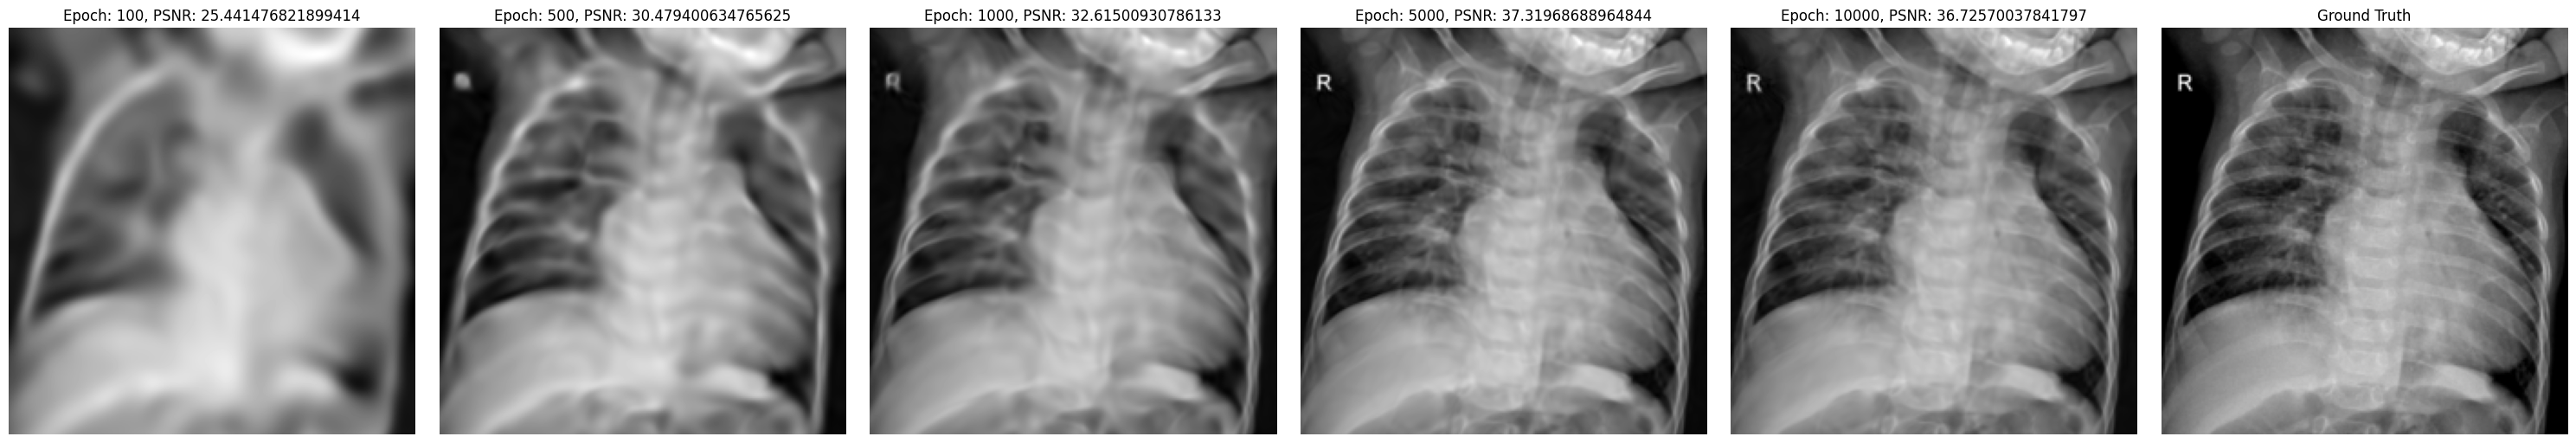

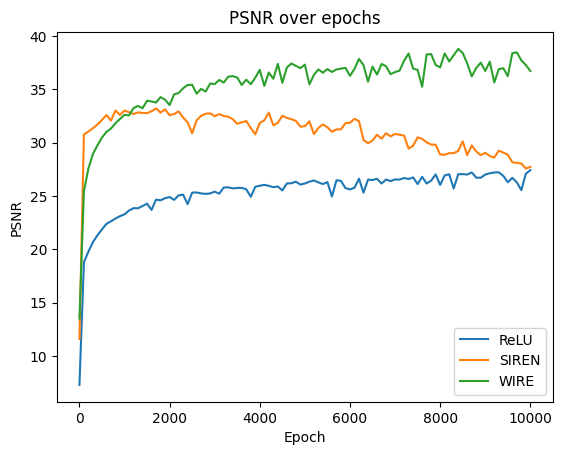

In [41]:
plot_reconstructions(wire_module.progress_ims, gt_image)
plot_scores([inr_module,
             siren_module,
             wire_module])